In [1]:
# In[1]: 라이브러리 임포트 및 기본 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math # 수학 연산이 필요할 경우를 위해 포함

# 시각화 기본 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid') # 격자 스타일로 깔끔하게
sns.set_palette("pastel") # 부드러운 색상 팔레트

# 한글 폰트 (나눔고딕) 설정
try:
    plt.rcParams['font.family'] = 'NanumGothic'
    print("나눔고딕 폰트가 성공적으로 설정되었습니다.")
except Exception as e:
    print(f"나눔고딕 폰트 설정에 실패했습니다: {e}.")
    print("그래프의 한글이 깨질 수 있습니다. 나눔고딕 폰트 설치를 권장합니다.")
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

# 변수 단위 정보 딕셔너리 (EDA 전반에 걸쳐 시각화 레이블에 활용)
VARIABLE_UNITS = {
    'cloud_cover': '(10분위)', 'dew_point': '(°C)', 'humidity': '(%)',
    'local_pressure': '(hPa)', 'min_cloud_height': '(100m)', 'precipitation': '(mm)',
    'sea_level_pressure': '(hPa)', 'snow_depth': '(cm)', 'sunshine_duration': '(hr)',
    'surface_temp': '(°C)', 'vapor_pressure': '(hPa)', 'visibility': '(10m)',
    'wind_speed': '(m/s)', 'wind_direction': '(°)',
    'climatology_temp': '(°C)', 'target': '(°C, 편차)'
    # 만약 resolve_missing_values (3).ipynb에서 추가된 주요 파생 변수가 있다면 여기에 단위 정보 추가 가능
    # 예: 'surface_temp_daily_avg': '(°C, 일평균)'
}

def get_unit(column_name_or_base):
    """ 컬럼명 또는 기본 변수명으로 단위를 찾아 반환하는 헬퍼 함수.
        예: get_unit('surface_temp_12') 또는 get_unit('surface_temp') 또는 get_unit('target')
    """
    for base_key, unit_value in VARIABLE_UNITS.items():
        # 컬럼명에 base_key가 포함되어 있으면 해당 단위를 반환 (예: 'surface_temp_0' -> '(°C)')
        if base_key in column_name_or_base:
            return unit_value
    return "" # 단위를 찾지 못한 경우 빈 문자열 반환

# --- 전처리 완료된 데이터 로드 ---
# resolve_missing_values (3).ipynb 파일에서 'train_df_imputed'를 어떤 이름과 경로로 저장했는지에 따라 수정 필요.
# 여기서는 예시로 './output/train_df_imputed.csv' 경로에 저장되었다고 가정합니다.
PROCESSED_DATA_FILE_PATH = './input/processed/train_df_imputed.csv' # 저장 경로 및 파일명 확인 필요

try:
    # 저장된 전처리 완료 데이터 로드
    # Parquet 형식으로 저장했다면 pd.read_parquet(PROCESSED_DATA_FILE_PATH) 사용
    train_df_analysis = pd.read_csv(PROCESSED_DATA_FILE_PATH)
    print(f"성공: '{PROCESSED_DATA_FILE_PATH}' 에서 전처리된 학습 데이터를 로드했습니다.")
    print(f"로드된 데이터 형태 (Shape): {train_df_analysis.shape}")

    # 필요한 경우 테스트 데이터도 동일한 방식으로 로드
    # PROCESSED_TEST_DATA_FILE_PATH = './output/test_df_imputed.csv'
    # test_df_analysis = pd.read_csv(PROCESSED_TEST_DATA_FILE_PATH)
    # print(f"성공: '{PROCESSED_TEST_DATA_FILE_PATH}' 에서 전처리된 테스트 데이터를 로드했습니다.")
    # print(f"로드된 테스트 데이터 형태 (Shape): {test_df_analysis.shape}")

except FileNotFoundError:
    print(f"경고: '{PROCESSED_DATA_FILE_PATH}' 파일을 찾을 수 없습니다!")
    print("      이전 전처리 노트북 (`resolve_missing_values (3).ipynb` 등)에서")
    print("      처리된 데이터프레임(예: `train_df_imputed`)을 해당 경로에 파일로 저장했는지 확인해주세요.")
    print("      (예: `train_df_imputed.to_csv('./output/train_df_imputed.csv', index=False)`)")
    print("      파일 로드 실패로 인해 이후 EDA가 정상적으로 동작하지 않을 수 있습니다.")
    # 파일 로드 실패 시, 이후 셀에서 train_df_analysis 변수가 없어 오류 발생함.
    # 계속 진행하려면 아래의 임시 데이터 생성 코드 주석을 해제해야 하지만,
    # 이는 실제 분석이 아니므로 권장되지 않음.
    # print("      임시 데이터를 생성하여 EDA를 진행합니다 (실제 데이터와 다름).")
    # num_rows_imputed = 13132
    # data_imputed = {'target': np.random.randn(num_rows_imputed)} # 최소한의 데이터
    # train_df_analysis = pd.DataFrame(data_imputed)


# 'month' 컬럼 존재 여부 확인 및 생성 (만약 전처리 파일에서 생성 안했다면)
# 일반적으로 'date' 컬럼은 전처리 단계에서 'month', 'day', 'year' 등으로 분해됨.
# 여기서는 'month'가 필요하다고 가정하고, 'date' 컬럼이 '월-일' 형식일 경우를 대비.
if 'month' not in train_df_analysis.columns and 'date' in train_df_analysis.columns:
    try:
        # 만약 'date' 컬럼이 'YYYY-MM-DD' 형식이라면 pd.to_datetime(train_df_analysis['date']).dt.month
        # 프로젝트 설명에는 '월-일' 형식이므로, 해당 형식에 맞춰 파싱 시도
        train_df_analysis['month'] = pd.to_datetime(train_df_analysis['date'], format='%m-%d', errors='coerce').dt.month
        print("'month' 컬럼을 'date' 컬럼으로부터 생성했습니다.")
    except Exception as e:
        print(f"'date' 컬럼에서 'month' 추출 중 오류 발생: {e}. 'month' 컬럼이 필요한 분석에 문제가 있을 수 있습니다.")
        print("  'date' 컬럼의 형식을 확인하거나, 전처리 단계에서 'month'를 미리 생성해주세요.")

# 데이터 로드 후 기본 정보 확인 (선택 사항)
# print("\n--- 로드된 데이터(train_df_analysis) 기본 정보 ---")
# print(train_df_analysis.head())
# train_df_analysis.info()

print("\n--- 상세 EDA (전처리 완료 데이터 사용) 준비 완료 ---")
# 이제 이 train_df_analysis 변수를 사용하여 상세 EDA의 나머지 부분 (1번~6번 분석)을 진행합니다.



나눔고딕 폰트가 성공적으로 설정되었습니다.
성공: './input/processed/train_df_imputed.csv' 에서 전처리된 학습 데이터를 로드했습니다.
로드된 데이터 형태 (Shape): (13132, 342)
'month' 컬럼을 'date' 컬럼으로부터 생성했습니다.

--- 상세 EDA (전처리 완료 데이터 사용) 준비 완료 ---


<Figure size 1000x50 with 0 Axes>

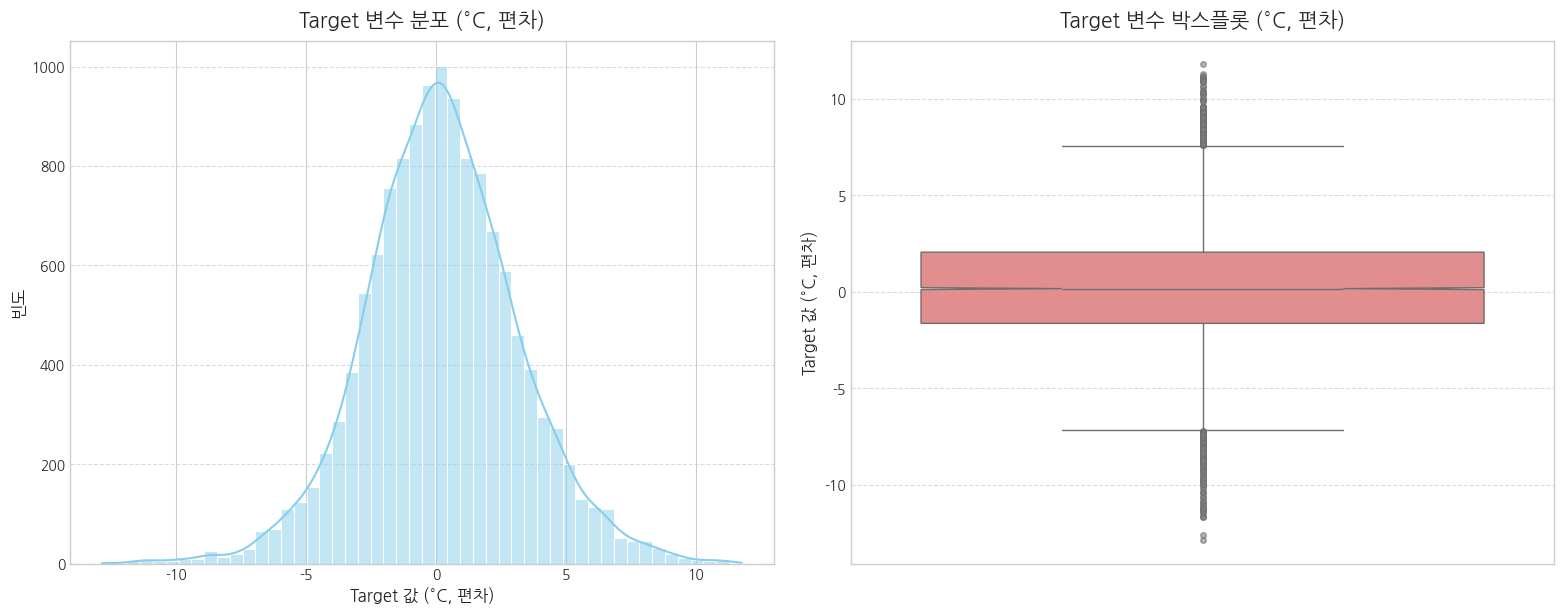


--- Target 변수의 기술 통계량 (NaN 값 제외) ---
  - 데이터 개수 (count): 13,132 개
  - 평균 (mean): 0.222 (°C, 편차)
  - 표준편차 (std): 2.961 (°C, 편차)
  - 최소값 (min): -12.864 (°C, 편차)
  - 제1사분위수 (25%): -1.643 (°C, 편차)
  - 중앙값 (median, 50%): 0.157 (°C, 편차)
  - 제3사분위수 (75%): 2.046 (°C, 편차)
  - 최대값 (max): 11.779 (°C, 편차)

--- Target 값의 편차 방향성 분석 (NaN 값 제외) ---
  - 과거 평균과 동일 (0인 경우): 0.02%
  - 과거 평균보다 더움 (양수인 경우): 52.45%
  - 과거 평균보다 추움 (음수인 경우): 47.53%


In [2]:
# In[2]: 1. Target 변수 상세 분석 (결측치 처리 후)
if 'target' in train_df_analysis.columns:
    fig_title_target = plt.figure(figsize=(10, 0.5)) # 제목용 더미 Figure
    plt.figtext(0.5, 0.5, '1. Target 변수 상세 분석 (전처리 후)',
                ha='center', va='center', fontsize=18, weight='bold', figure=fig_title_target)
    plt.show(fig_title_target) # 더미 figure 표시

    fig, axes = plt.subplots(1, 2, figsize=(16, 6.5))
    target_unit = get_unit('target')
    target_data_for_plot = train_df_analysis['target'].dropna()

    if not target_data_for_plot.empty:
        # 히스토그램 및 KDE
        # --- 오류 수정: kde_kws에서 시각화 관련 인자(linewidth, color) 제거 ---
        # KDE 라인의 스타일은 seaborn의 기본값을 따르거나,
        # 필요하다면 histplot을 그린 후 반환된 ax 객체를 통해 라인 속성을 직접 수정해야 합니다.
        sns.histplot(target_data_for_plot,
                     kde=True,
                     bins=50,
                     color='skyblue', # 히스토그램 막대 색상
                     ax=axes[0]
                     # kde_kws={} # 비워두거나, KDE 추정 관련 파라미터만 전달 (예: bw_method)
                    )
        # 만약 KDE 라인 색상/굵기를 꼭 바꾸고 싶다면, 아래와 같이 시도해볼 수 있습니다 (단, 라인이 하나만 그려진다는 가정):
        # try:
        #     if axes[0].lines: # 그려진 라인이 있다면
        #         kde_line = axes[0].lines[0]
        #         kde_line.set_color('navy')
        #         kde_line.set_linewidth(2)
        # except Exception as e_line:
        #     print(f"KDE 라인 스타일 수정 중 오류: {e_line}")
        # -------------------------------------------------------------------

        axes[0].set_title(f'Target 변수 분포 {target_unit}', fontsize=15, pad=10)
        axes[0].set_xlabel(f'Target 값 {target_unit}', fontsize=12)
        axes[0].set_ylabel('빈도', fontsize=12)
        axes[0].tick_params(axis='both', which='major', labelsize=10)
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)

        # 박스플롯 (이 부분은 문제 없음)
        sns.boxplot(y=target_data_for_plot, ax=axes[1], color='lightcoral', notch=True,
                    flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor': 'gray', 'alpha':0.6})
        axes[1].set_title(f'Target 변수 박스플롯 {target_unit}', fontsize=15, pad=10)
        axes[1].set_ylabel(f'Target 값 {target_unit}', fontsize=12)
        axes[1].tick_params(axis='y', which='major', labelsize=10)
        axes[1].tick_params(axis='x', which='major', bottom=False, labelbottom=False)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout(pad=2.0)
        plt.show()

        print("\n--- Target 변수의 기술 통계량 (NaN 값 제외) ---")
        target_stats = target_data_for_plot.describe()
        print(f"  - 데이터 개수 (count): {target_stats.get('count', 'N/A'):,.0f} 개")
        print(f"  - 평균 (mean): {target_stats.get('mean', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 표준편차 (std): {target_stats.get('std', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 최소값 (min): {target_stats.get('min', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 제1사분위수 (25%): {target_stats.get('25%', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 중앙값 (median, 50%): {target_stats.get('50%', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 제3사분위수 (75%): {target_stats.get('75%', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 최대값 (max): {target_stats.get('max', 'N/A'):.3f} {target_unit.strip()}")

        print("\n--- Target 값의 편차 방향성 분석 (NaN 값 제외) ---")
        print(f"  - 과거 평균과 동일 (0인 경우): {(target_data_for_plot == 0).mean() * 100:.2f}%")
        print(f"  - 과거 평균보다 더움 (양수인 경우): {(target_data_for_plot > 0).mean() * 100:.2f}%")
        print(f"  - 과거 평균보다 추움 (음수인 경우): {(target_data_for_plot < 0).mean() * 100:.2f}%")
    else:
        print("경고: 'target' 데이터가 (NaN 제거 후) 비어있어 분석을 수행할 수 없습니다.")
else:
    print("경고: 'target' 컬럼이 train_df_analysis에 없습니다. Target 변수 분석을 건너<0xEB><0A><0x88>니다.")




<Figure size 1000x50 with 0 Axes>

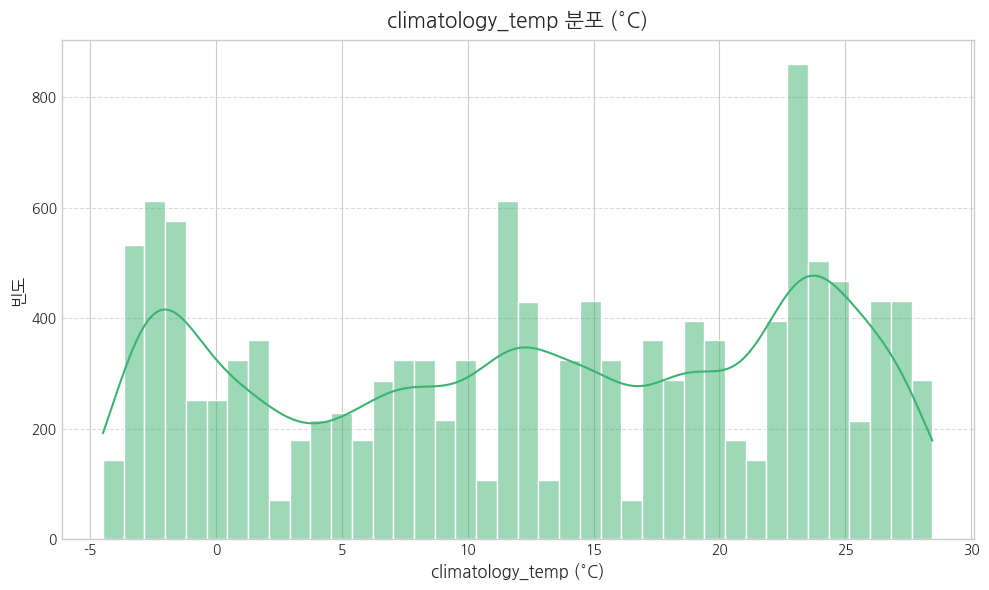


--- climatology_temp 변수의 기술 통계량 (NaN 값 제외) ---
  - 데이터 개수 (count): 13,132 개
  - 평균 (mean): 12.66 (°C)
  - 표준편차 (std): 10.02 (°C)
  - 최소값 (min): -4.49 (°C)
  - 제1사분위수 (25%): 3.29 (°C)
  - 중앙값 (median, 50%): 12.84 (°C)
  - 제3사분위수 (75%): 22.27 (°C)
  - 최대값 (max): 28.46 (°C)


In [3]:
# In[3]: 2. climatology_temp 분석 (결측치 처리 후)
if 'climatology_temp' in train_df_analysis.columns:
    col_name_clima = 'climatology_temp'
    unit_clima = get_unit(col_name_clima)

    fig_title_clima = plt.figure(figsize=(10, 0.5))
    plt.figtext(0.5, 0.5, '2. climatology_temp (당일 과거 평균 기온) 분석 (전처리 후)',
                ha='center', va='center', fontsize=18, weight='bold', figure=fig_title_clima)
    plt.show(fig_title_clima)

    plt.figure(figsize=(10, 6))
    # 전처리된 데이터이므로 .dropna()는 큰 의미 없을 수 있으나 안전을 위해 사용
    clima_data_for_plot = train_df_analysis[col_name_clima].dropna()
    if not clima_data_for_plot.empty:
        sns.histplot(clima_data_for_plot, kde=True, bins=40, color='mediumseagreen')
        plt.title(f'{col_name_clima} 분포 {unit_clima}', fontsize=15, pad=10)
        plt.xlabel(f'{col_name_clima} {unit_clima}', fontsize=12)
        plt.ylabel('빈도', fontsize=12)
        plt.xticks(fontsize=10); plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

        print(f"\n--- {col_name_clima} 변수의 기술 통계량 (NaN 값 제외) ---")
        clima_stats_actual = clima_data_for_plot.describe()
        print(f"  - 데이터 개수 (count): {clima_stats_actual.get('count', 'N/A'):,.0f} 개")
        print(f"  - 평균 (mean): {clima_stats_actual.get('mean', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 표준편차 (std): {clima_stats_actual.get('std', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 최소값 (min): {clima_stats_actual.get('min', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 제1사분위수 (25%): {clima_stats_actual.get('25%', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 중앙값 (median, 50%): {clima_stats_actual.get('50%', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 제3사분위수 (75%): {clima_stats_actual.get('75%', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 최대값 (max): {clima_stats_actual.get('max', 'N/A'):.2f} {unit_clima.strip()}")
    else:
        print(f"경고: '{col_name_clima}' 데이터가 (NaN 제거 후) 비어있어 분석을 수행할 수 없습니다.")
else:
    print(f"경고: 'climatology_temp' 컬럼이 train_df_analysis에 없습니다.")




<Figure size 1000x50 with 0 Axes>


--------------- surface_temp (°C) 시간별 분석 ---------------


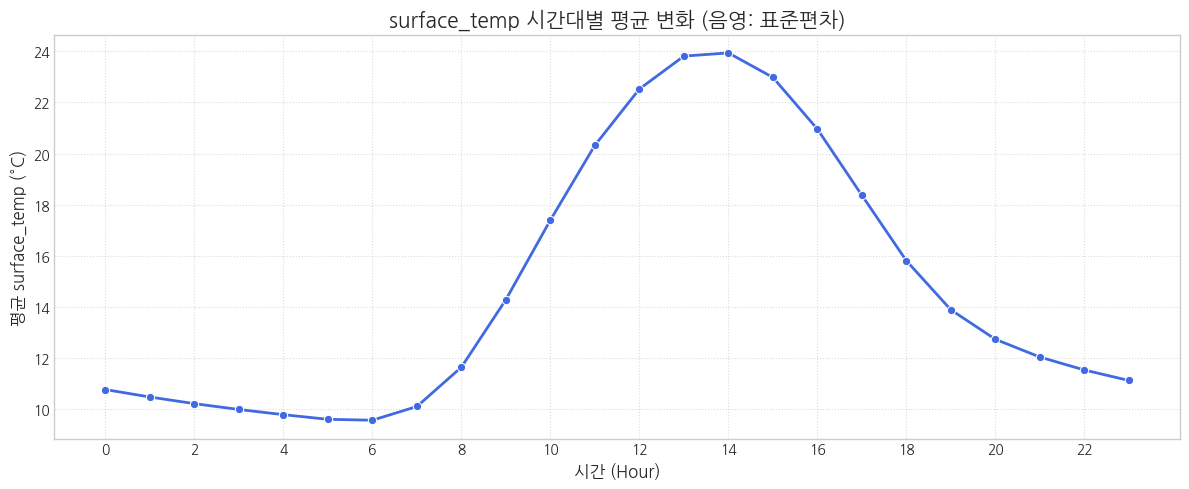

/var/folders/h_/c0f25gcs1pd849llchcxzyb80000gn/T/ipykernel_35457/2038744662.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",


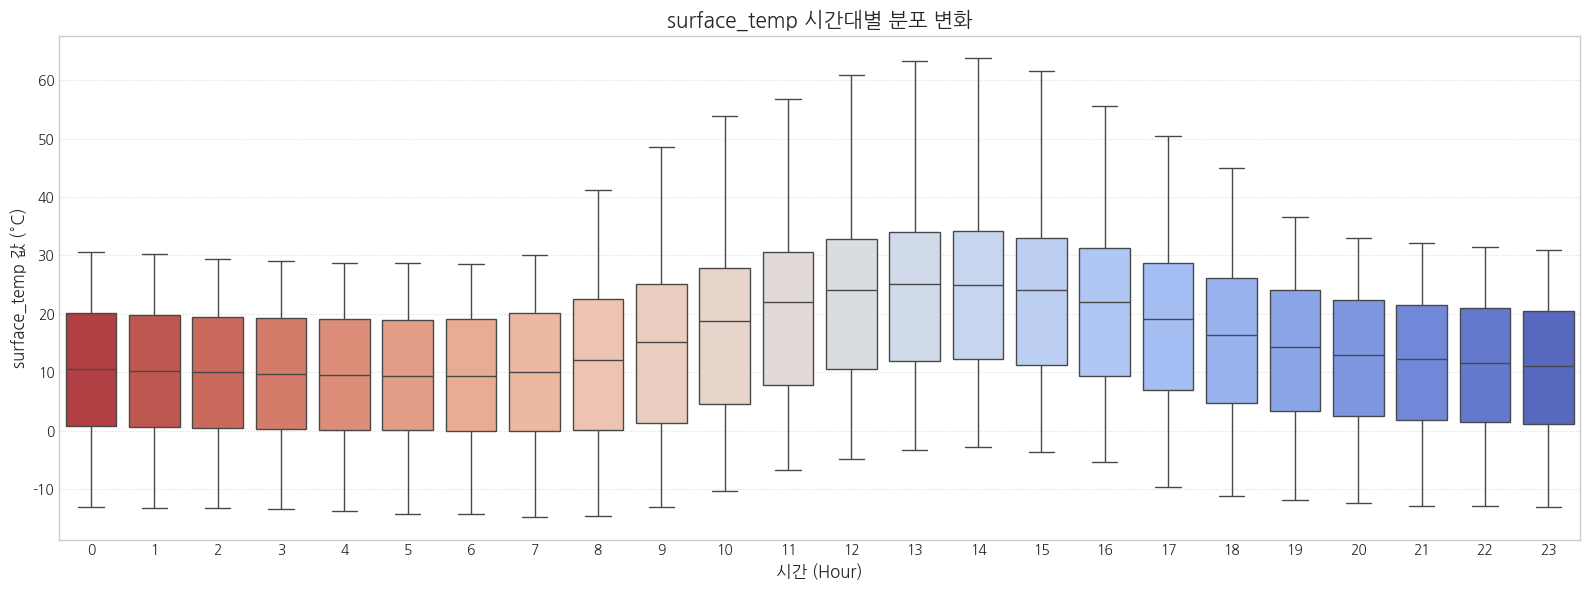


--------------- dew_point (°C) 시간별 분석 ---------------


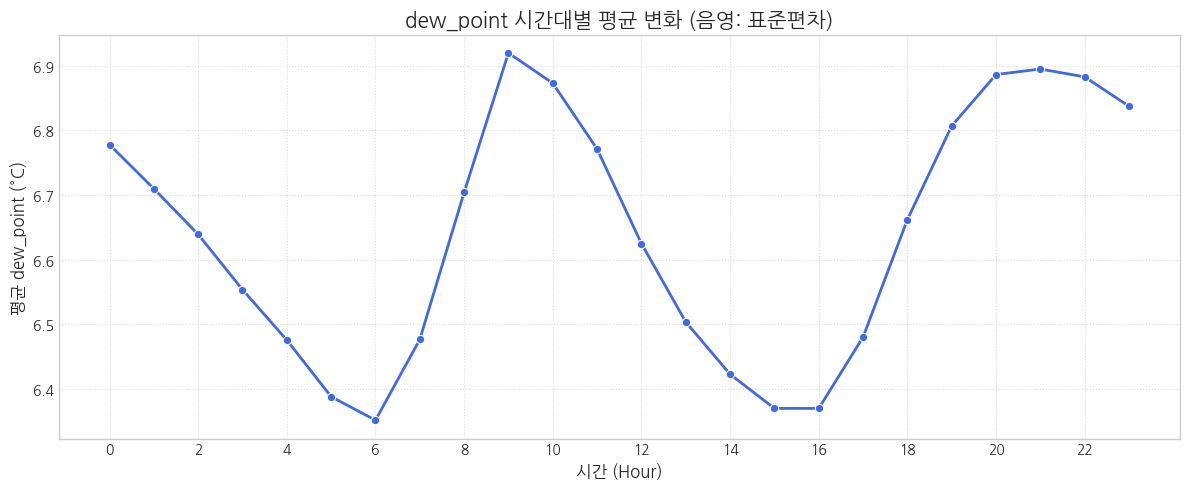

/var/folders/h_/c0f25gcs1pd849llchcxzyb80000gn/T/ipykernel_35457/2038744662.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",


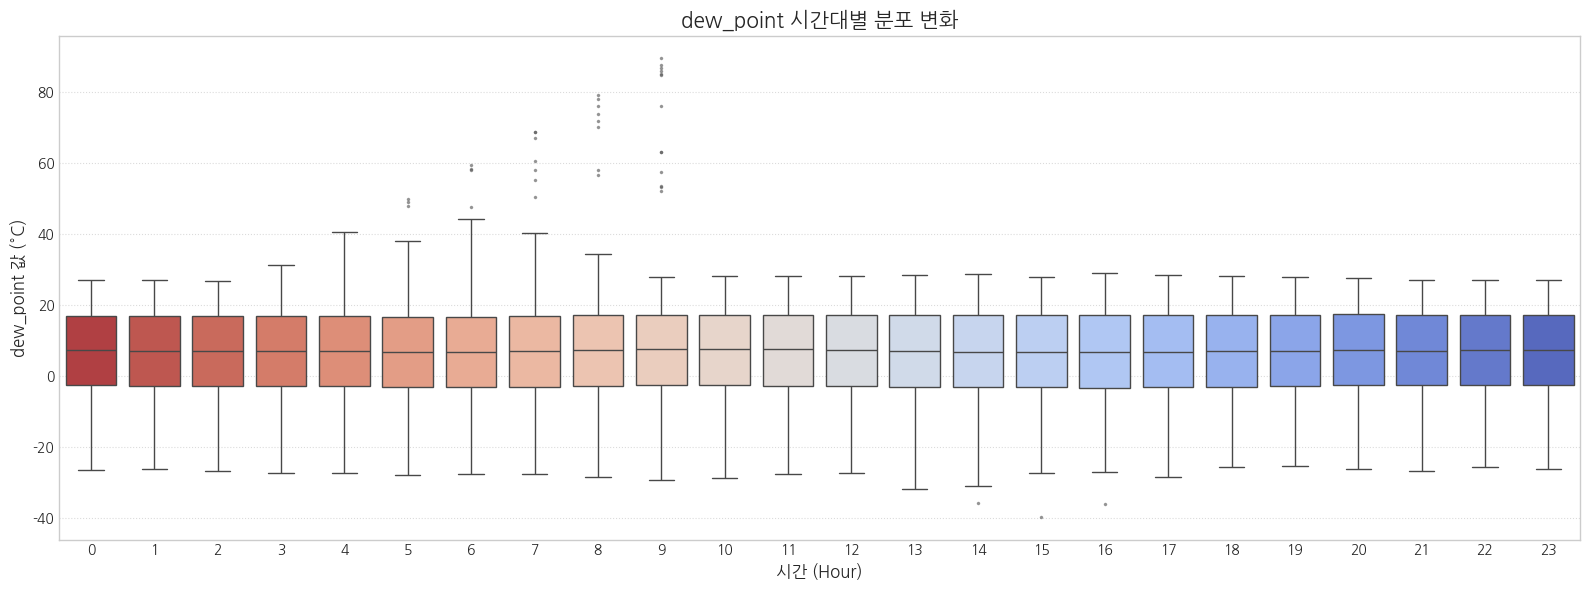


--------------- humidity (%) 시간별 분석 ---------------


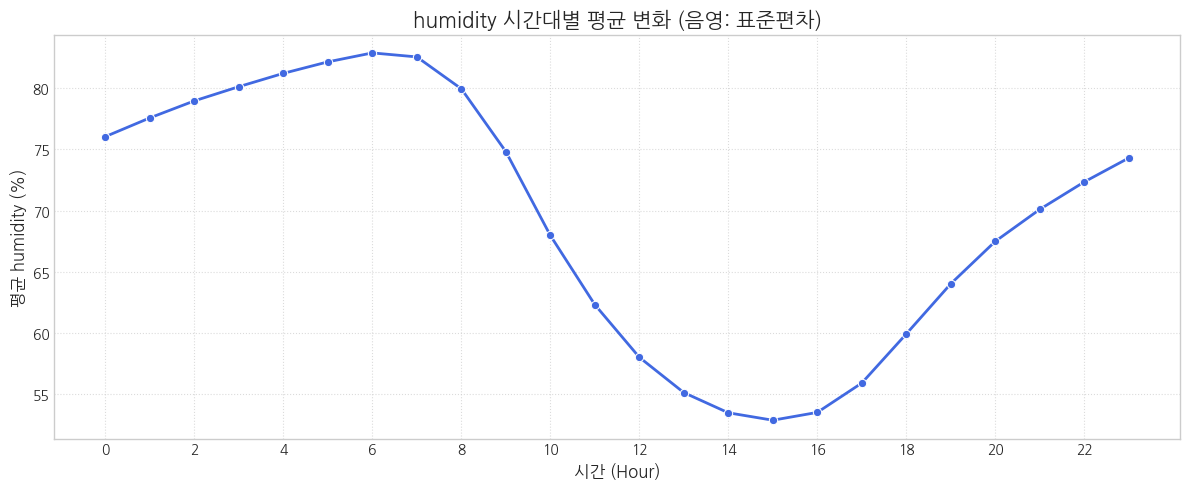

/var/folders/h_/c0f25gcs1pd849llchcxzyb80000gn/T/ipykernel_35457/2038744662.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",


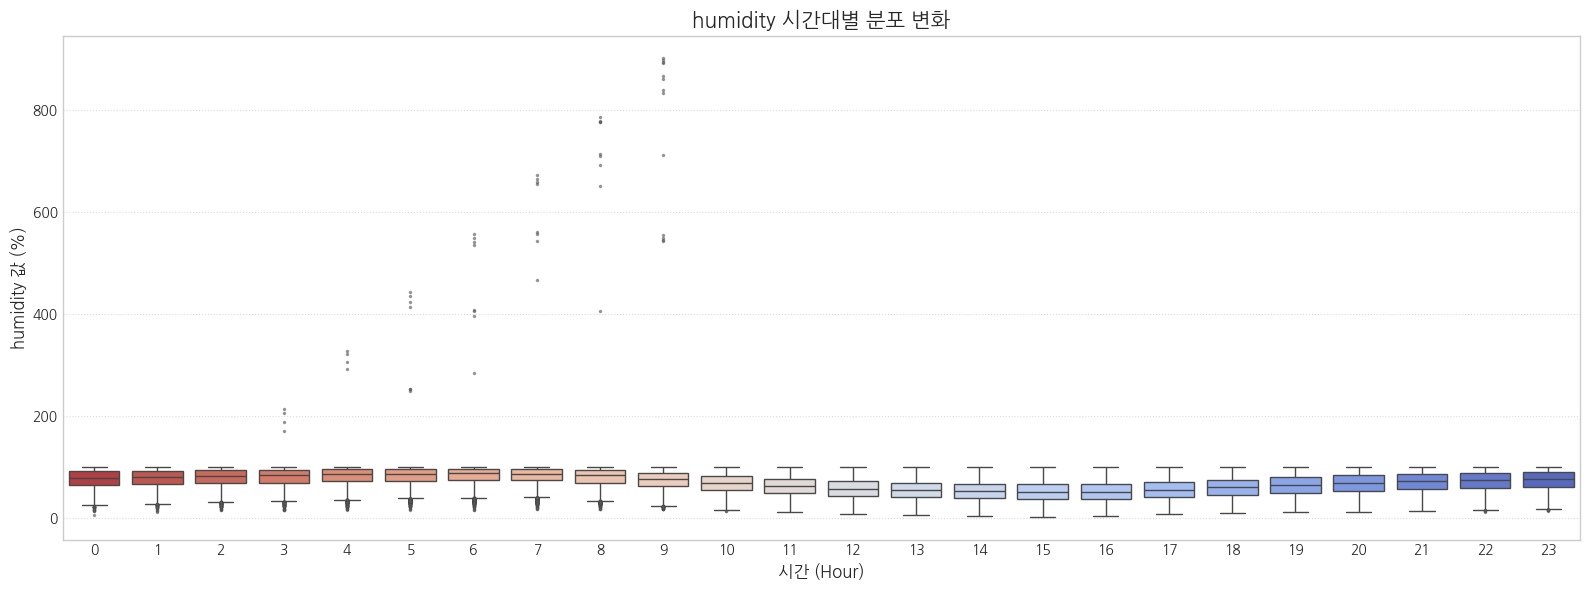


--------------- wind_speed (m/s) 시간별 분석 ---------------


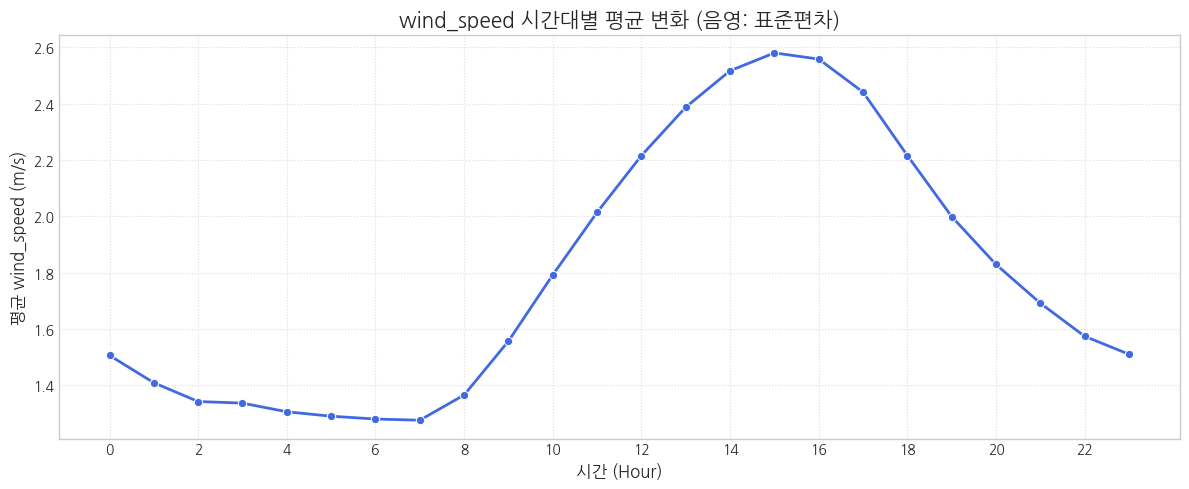

/var/folders/h_/c0f25gcs1pd849llchcxzyb80000gn/T/ipykernel_35457/2038744662.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",


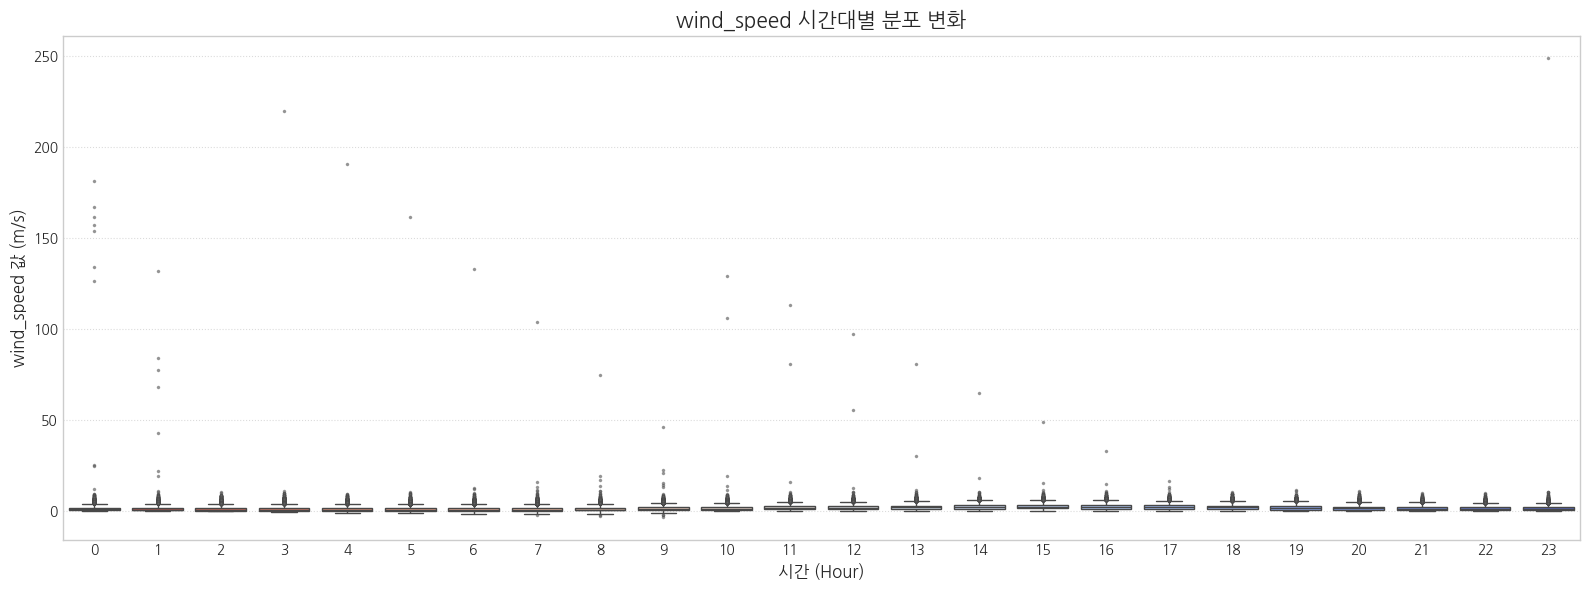


--------------- cloud_cover (10분위) 시간별 분석 ---------------


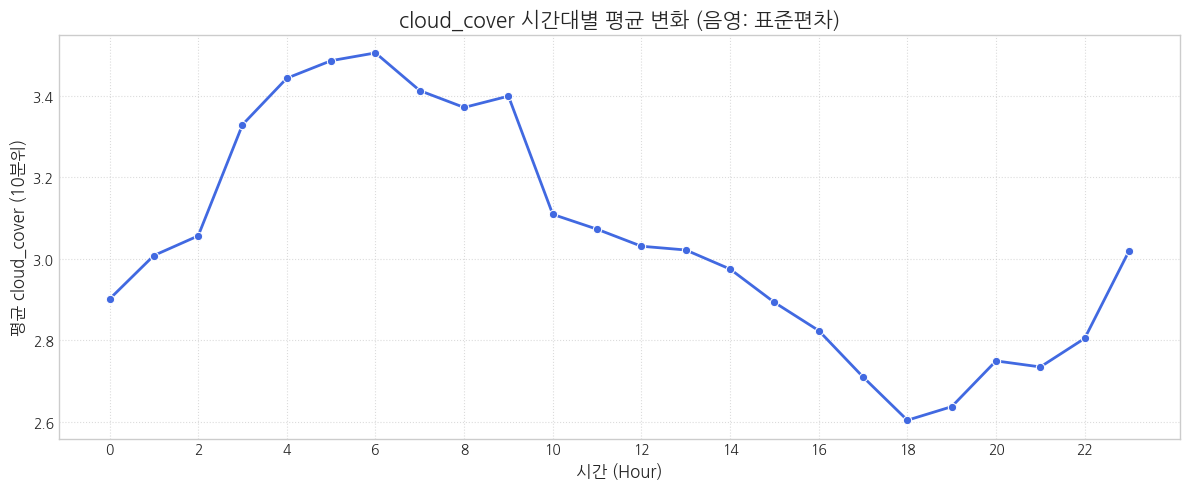

/var/folders/h_/c0f25gcs1pd849llchcxzyb80000gn/T/ipykernel_35457/2038744662.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",


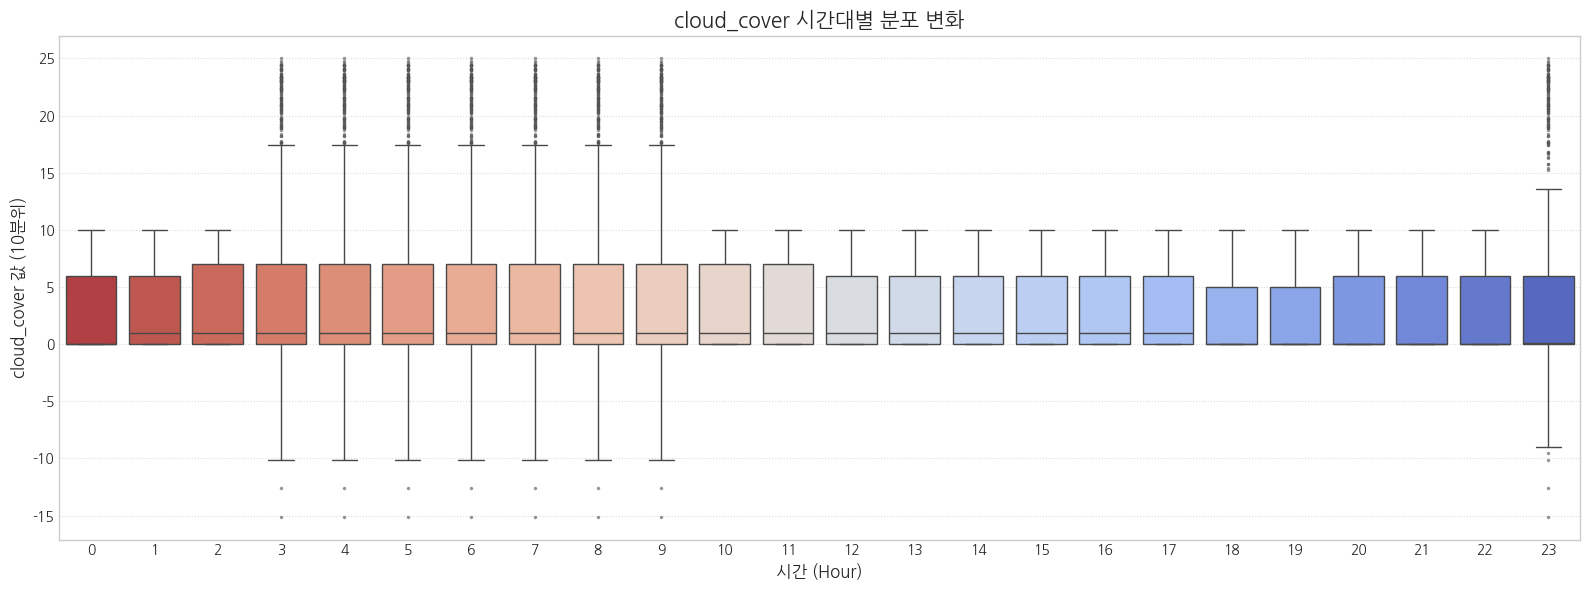

In [4]:
# In[4]: 3. 시간별 주요 기상 변수 분석 (결측치 처리 후)
HOURLY_FEATURES_TO_ANALYZE = {
    'surface_temp': 'surface_temp', 'dew_point': 'dew_point', 'humidity': 'humidity',
    'wind_speed': 'wind_speed', 'cloud_cover': 'cloud_cover'
    # 필요에 따라 sunshine_duration, snow_depth, precipitation 등 추가 (결측치 처리 후 값이 대부분 0일 수 있음)
}
# sunshine_duration, snow_depth, precipitation은 결측치 처리 후 대부분 0일 가능성이 높아
# 평균/분포 변화가 뚜렷하지 않을 수 있음. 이를 감안하고 포함 여부 결정.
# HOURLY_FEATURES_TO_ANALYZE['sunshine_duration'] = 'sunshine_duration'
# HOURLY_FEATURES_TO_ANALYZE['snow_depth'] = 'snow_depth'
# HOURLY_FEATURES_TO_ANALYZE['precipitation'] = 'precipitation'


fig_title_hourly = plt.figure(figsize=(10, 0.5))
plt.figtext(0.5, 0.5, '3. 시간별 주요 기상 변수 분석 (전처리 후)',
            ha='center', va='center', fontsize=18, weight='bold', figure=fig_title_hourly)
plt.show(fig_title_hourly)

if isinstance(HOURLY_FEATURES_TO_ANALYZE, dict):
    for base_feature_key, base_feature_name_for_unit in HOURLY_FEATURES_TO_ANALYZE.items():
        unit = get_unit(base_feature_name_for_unit)
        hourly_cols = [f"{base_feature_key}_{h}" for h in range(24)]
        existing_hourly_cols = [col for col in hourly_cols if col in train_df_analysis.columns]

        if not existing_hourly_cols:
            print(f"\n'{base_feature_key}'에 대한 시간별 컬럼을 train_df_analysis에서 찾을 수 없습니다. 건너<0xEB><0A><0x88>니다.")
            continue

        print(f"\n{'-'*15} {base_feature_key} {unit} 시간별 분석 {'-'*15}")

        # 시간대별 평균 추세 (라인 플롯)
        # 전처리된 데이터이므로 skipna=True는 큰 영향 없을 수 있으나, 혹시 모를 잔여 NaN 대비
        hourly_means = train_df_analysis[existing_hourly_cols].mean(axis=0, skipna=True)
        if hourly_means.isnull().all():
             print(f"'{base_feature_key}'의 모든 시간대 평균이 NaN입니다. 라인 플롯을 건너<0xEB><0A><0x88>니다.")
        else:
            hourly_means.index = [int(col.split('_')[-1]) for col in hourly_means.index]
            hourly_means = hourly_means.sort_index()
            plt.figure(figsize=(12, 5))
            sns.lineplot(x=hourly_means.index, y=hourly_means.values, marker='o', errorbar='sd', color='royalblue', lw=2)
            plt.title(f'{base_feature_key} 시간대별 평균 변화 (음영: 표준편차)', fontsize=15)
            plt.xlabel('시간 (Hour)', fontsize=12); plt.ylabel(f'평균 {base_feature_key} {unit}', fontsize=12)
            plt.xticks(range(0, 24, 2), fontsize=10); plt.yticks(fontsize=10)
            plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()

        # 시간대별 분포 변화 (박스플롯)
        melted_df = train_df_analysis[existing_hourly_cols].copy()
        if melted_df.isnull().all().all():
            print(f"'{base_feature_key}'의 모든 시간대 데이터가 NaN입니다. 박스플롯을 건너<0xEB><0A><0x88>니다.")
        else:
            melted_df.columns = [int(col.split('_')[-1]) for col in melted_df.columns]
            melted_df = melted_df.melt(var_name='hour', value_name=base_feature_key)
            melted_df_no_nan_boxplot = melted_df.dropna(subset=[base_feature_key]) # 혹시 모를 NaN 제거

            if not melted_df_no_nan_boxplot.empty:
                plt.figure(figsize=(16, 6))
                sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",
                            flierprops={'marker':'.', 'markersize':3, 'markerfacecolor':'gray', 'alpha':0.5})
                plt.title(f'{base_feature_key} 시간대별 분포 변화', fontsize=15)
                plt.xlabel('시간 (Hour)', fontsize=12); plt.ylabel(f'{base_feature_key} 값 {unit}', fontsize=12)
                plt.xticks(range(0, 24, 1), fontsize=10); plt.yticks(fontsize=10)
                plt.grid(True, axis='y', linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()
            else:
                print(f"'{base_feature_key}' 데이터가 (NaN 제거 후) 비어있어 박스플롯을 그릴 수 없습니다.")
else:
    print("경고: 'HOURLY_FEATURES_TO_ANALYZE' 딕셔너리가 정의되지 않았습니다. 시간별 분석을 건너<0xEB><0A><0x88>니다.")




<Figure size 1000x50 with 0 Axes>

/var/folders/h_/c0f25gcs1pd849llchcxzyb80000gn/T/ipykernel_35457/943024777.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='target', data=monthly_target_data, palette="Spectral", notch=True,


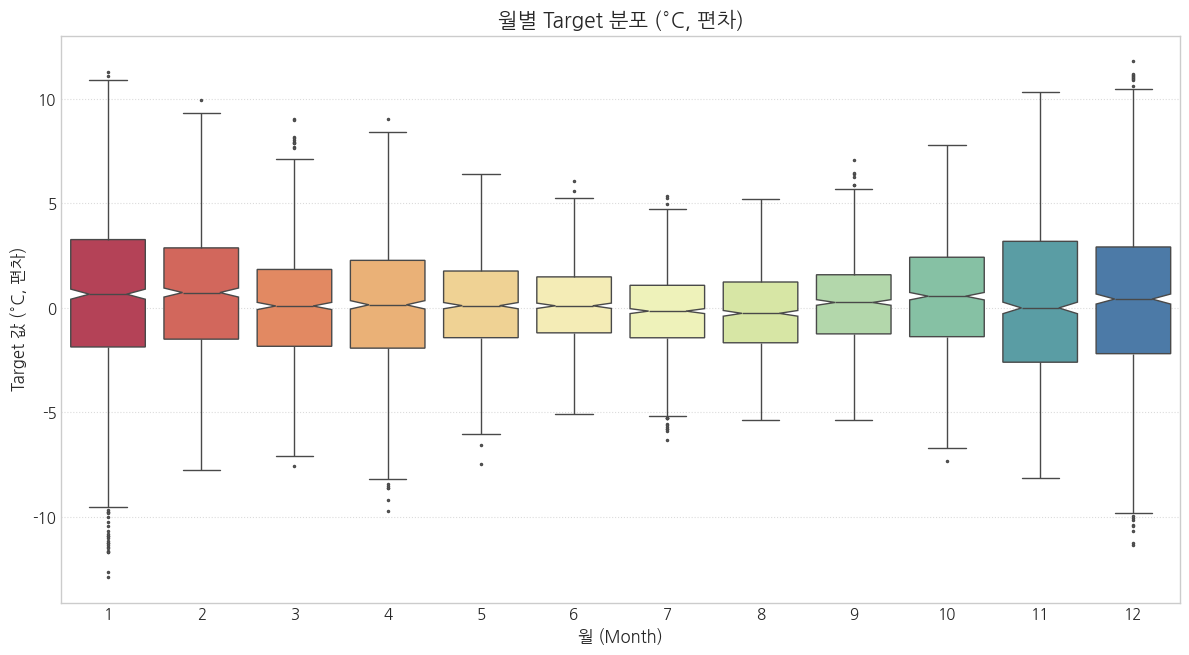

In [5]:
# In[5]: 4. 월별 Target 변화 분석 (결측치 처리 후)
if 'target' in train_df_analysis.columns and 'month' in train_df_analysis.columns:
    fig_title_month = plt.figure(figsize=(10, 0.5))
    plt.figtext(0.5, 0.5, '4. 월별 Target 변화 분석 (전처리 후)',
                ha='center', va='center', fontsize=18, weight='bold', figure=fig_title_month)
    plt.show(fig_title_month)

    plt.figure(figsize=(12, 7))
    target_unit_month = get_unit('target')
    # Target 및 month 컬럼에서 NaN 값을 가진 행은 박스플롯에서 제외
    monthly_target_data = train_df_analysis[['month', 'target']].dropna()

    if not monthly_target_data.empty and monthly_target_data['month'].nunique() > 0 :
        sns.boxplot(x='month', y='target', data=monthly_target_data, palette="Spectral", notch=True,
                    flierprops={'marker':'.', 'markersize':3, 'markerfacecolor':'gray'})
        plt.title(f'월별 Target 분포 {target_unit_month}', fontsize=15)
        plt.xlabel('월 (Month)', fontsize=12); plt.ylabel(f'Target 값 {target_unit_month}', fontsize=12)
        # 월 데이터가 연속적이지 않을 수 있으므로, 있는 월만 표시하도록 함
        month_order = sorted(monthly_target_data['month'].unique().astype(int))
        plt.xticks(ticks=[m-1 for m in month_order], labels=month_order, fontsize=11) # 0부터 시작하는 tick 위치에 맞춤
        plt.yticks(fontsize=11)
        plt.grid(True, axis='y', linestyle=':', alpha=0.7); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()
    else:
        print("경고: 'target' 또는 'month' 데이터가 부족하거나 (NaN 제거 후) 비어있어 월별 Target 분석을 수행할 수 없습니다.")
else:
    print("경고: 'target' 또는 'month' 컬럼이 없어 월별 Target 분석을 건너<0xEB><0A><0x88>니다.")




<Figure size 1000x50 with 0 Axes>

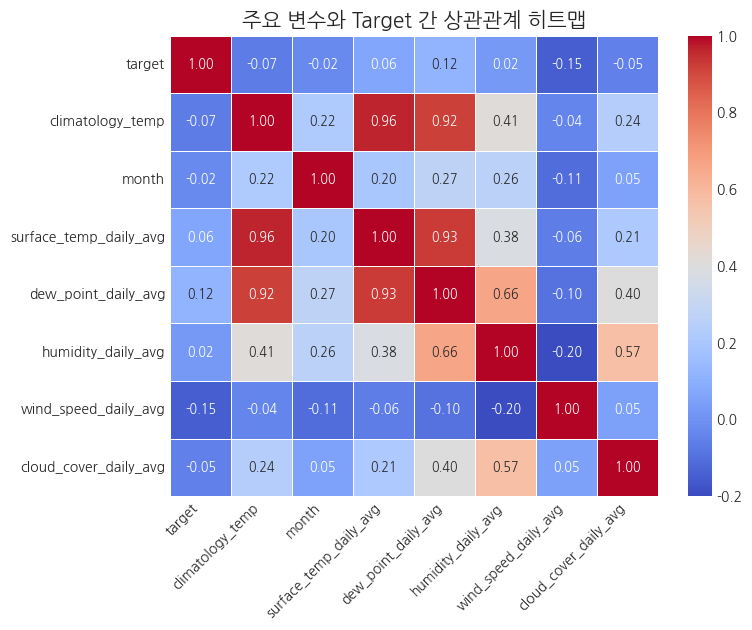


--- Target과의 상관계수 (절대값 높은 순) ---
target                    1.000000
wind_speed_daily_avg      0.150629
dew_point_daily_avg       0.116530
climatology_temp          0.067867
surface_temp_daily_avg    0.064782
cloud_cover_daily_avg     0.051942
month                     0.024693
humidity_daily_avg        0.023139
Name: target, dtype: float64


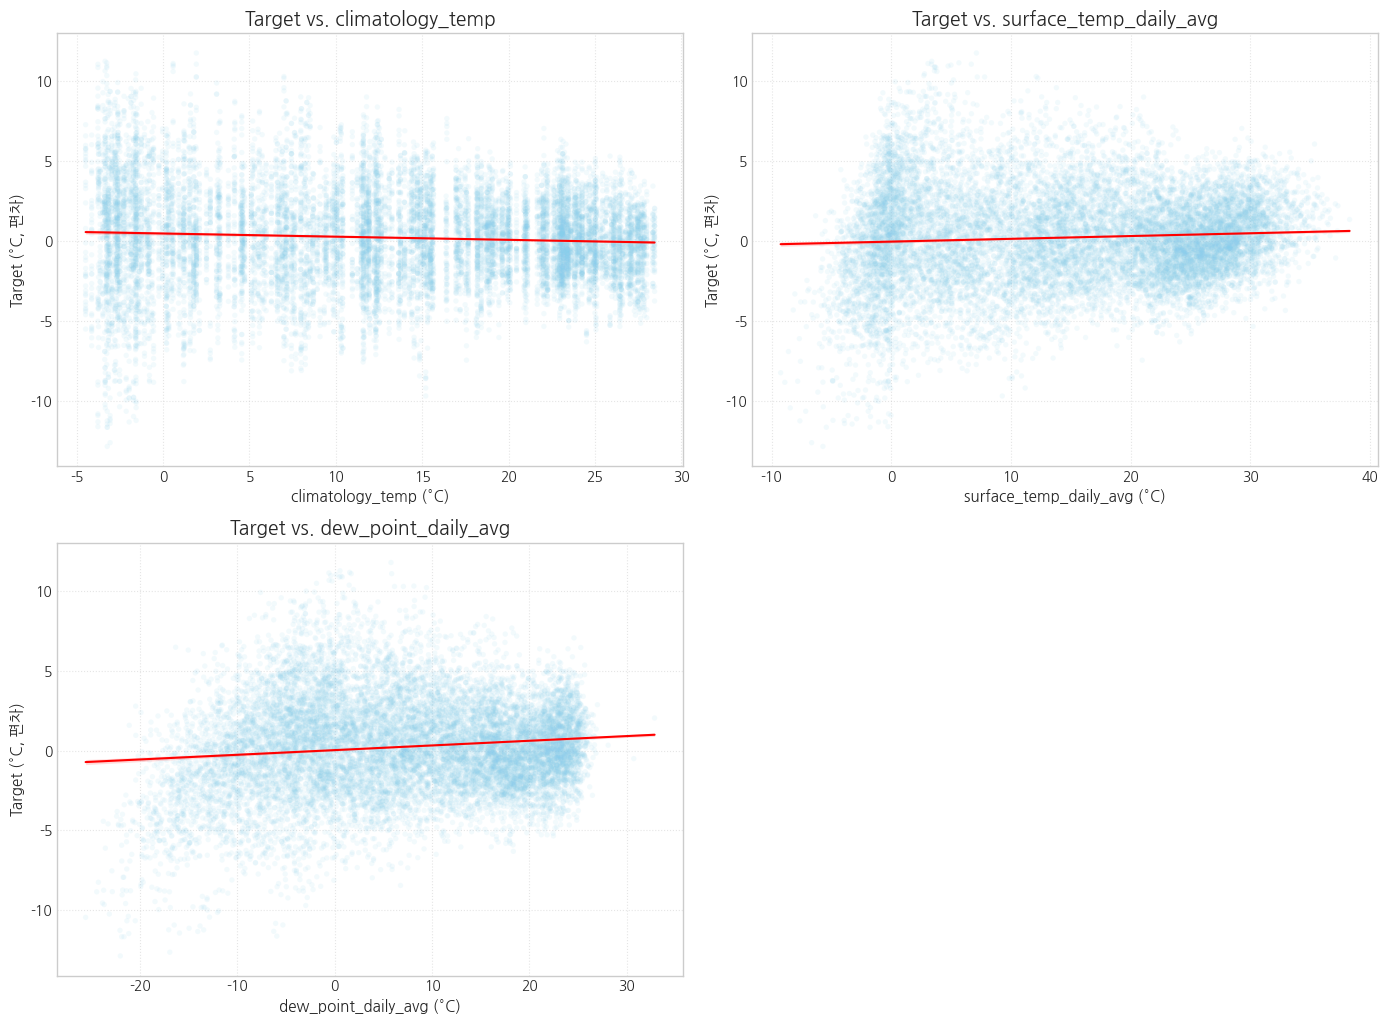

In [6]:
# In[6]: 5. 주요 변수와 Target 간의 관계 분석 (결측치 처리 후)
if 'target' in train_df_analysis.columns and not train_df_analysis['target'].isnull().all():
    fig_title_corr = plt.figure(figsize=(10, 0.5))
    plt.figtext(0.5, 0.5, '5. 주요 변수와 Target 간 관계 분석 (전처리 후)',
                ha='center', va='center', fontsize=18, weight='bold', figure=fig_title_corr)
    plt.show(fig_title_corr)

    # 상관관계 분석용 데이터프레임 생성 (target이 NaN이 아닌 행만 사용)
    # 또한, 이후 생성될 일평균 변수들도 NaN일 수 있으므로, 최종적으로 corr() 전에 dropna() 필요
    corr_df_analysis_base = train_df_analysis.dropna(subset=['target']).copy()
    target_unit_corr = get_unit('target')

    cols_for_corr_heatmap = ['target'] # 히트맵에 포함될 최종 컬럼 리스트
    if 'climatology_temp' in corr_df_analysis_base.columns:
        cols_for_corr_heatmap.append('climatology_temp')
    if 'month' in corr_df_analysis_base.columns:
        cols_for_corr_heatmap.append('month')

    # 주요 시간별 변수의 일평균값 추가 (HOURLY_FEATURES_TO_ANALYZE 사용)
    # 이 부분은 Feature Engineering 단계에서 더 정교하게 다룰 수 있음. EDA에서는 간략히.
    if 'HOURLY_FEATURES_TO_ANALYZE' in locals() and isinstance(HOURLY_FEATURES_TO_ANALYZE, dict):
        for base_feature_key, base_feature_name in HOURLY_FEATURES_TO_ANALYZE.items():
            daily_avg_col_name = f'{base_feature_key}_daily_avg' # 예: surface_temp_daily_avg
            hourly_cols_for_avg = [f"{base_feature_key}_{h}" for h in range(24) if f"{base_feature_key}_{h}" in corr_df_analysis_base.columns]
            if hourly_cols_for_avg:
                # skipna=True: 시간별 데이터 중 일부만 NaN일 경우, 있는 값들로만 평균 계산
                corr_df_analysis_base[daily_avg_col_name] = corr_df_analysis_base[hourly_cols_for_avg].mean(axis=1, skipna=True)
                if daily_avg_col_name not in cols_for_corr_heatmap and not corr_df_analysis_base[daily_avg_col_name].isnull().all(): # 모두 NaN인 컬럼은 제외
                     cols_for_corr_heatmap.append(daily_avg_col_name)
    
    # 숫자형이고, 모든 값이 NaN이 아닌 컬럼만 최종 선택
    final_cols_for_heatmap = [col for col in cols_for_corr_heatmap if col in corr_df_analysis_base.columns and pd.api.types.is_numeric_dtype(corr_df_analysis_base[col]) and not corr_df_analysis_base[col].isnull().all()]

    if len(final_cols_for_heatmap) > 1:
        # 상관계수 계산 전에 한 번 더 NaN 처리 (일평균 계산 시 일부 행에 NaN이 생길 수 있음)
        correlation_matrix = corr_df_analysis_base[final_cols_for_heatmap].dropna().corr()
        
        if not correlation_matrix.empty and 'target' in correlation_matrix.columns:
            plt.figure(figsize=(max(8, len(final_cols_for_heatmap)*0.9), max(6, len(final_cols_for_heatmap)*0.8)))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,
                        annot_kws={"size":9 if len(final_cols_for_heatmap) < 10 else 7})
            plt.title('주요 변수와 Target 간 상관관계 히트맵', fontsize=15)
            plt.xticks(rotation=45, ha='right', fontsize=10 if len(final_cols_for_heatmap) < 10 else 8)
            plt.yticks(rotation=0, fontsize=10 if len(final_cols_for_heatmap) < 10 else 8)
            plt.tight_layout(); plt.show()

            print(f"\n--- Target과의 상관계수 (절대값 높은 순) ---")
            print(correlation_matrix['target'].abs().sort_values(ascending=False))

            # 산점도 (Target과 상관성이 높은 상위 N개 변수 또는 주요 변수 선택)
            scatter_plot_vars_dict = {}
            if 'climatology_temp' in final_cols_for_heatmap:
                 scatter_plot_vars_dict['climatology_temp'] = 'climatology_temp'
            if 'surface_temp_daily_avg' in final_cols_for_heatmap: # 예시 일평균 변수
                 scatter_plot_vars_dict['surface_temp_daily_avg'] = 'surface_temp'
            if 'dew_point_daily_avg' in final_cols_for_heatmap: # 예시 일평균 변수
                 scatter_plot_vars_dict['dew_point_daily_avg'] = 'dew_point'

            if scatter_plot_vars_dict:
                num_scatter = len(scatter_plot_vars_dict)
                if num_scatter > 0:
                    n_cols_sc = min(num_scatter, 2); n_rows_sc = math.ceil(num_scatter / n_cols_sc)
                    fig_sc, axes_sc = plt.subplots(n_rows_sc, n_cols_sc, figsize=(n_cols_sc * 7, n_rows_sc * 5.5), squeeze=False)
                    axes_sc = axes_sc.flatten(); plot_idx_sc = 0
                    for col_to_plot, base_name_for_unit in scatter_plot_vars_dict.items():
                        # corr_df_analysis_base에서 NaN이 아닌 target과 해당 컬럼 데이터 사용
                        plot_data_scatter = corr_df_analysis_base[['target', col_to_plot]].dropna()
                        if not plot_data_scatter.empty and col_to_plot != 'target':
                            unit_sc = get_unit(base_name_for_unit); ax_current = axes_sc[plot_idx_sc]
                            sns.regplot(x=plot_data_scatter[col_to_plot], y=plot_data_scatter['target'], ax=ax_current,
                                        scatter_kws={'alpha':0.1, 's':15, 'color':'skyblue', 'edgecolor':'none'},
                                        line_kws={'color':'red', 'lw':1.5})
                            ax_current.set_title(f'Target vs. {col_to_plot}', fontsize=14)
                            ax_current.set_xlabel(f'{col_to_plot} {unit_sc}', fontsize=11)
                            ax_current.set_ylabel(f'Target {target_unit_corr}', fontsize=11)
                            ax_current.tick_params(axis='both', which='major', labelsize=10)
                            ax_current.grid(True, linestyle=':', alpha=0.5); plot_idx_sc += 1
                    for i in range(plot_idx_sc, len(axes_sc)): fig_sc.delaxes(axes_sc[i])
                    fig_sc.tight_layout(rect=[0, 0.02, 1, 0.96]); plt.show()
                else: print("산점도를 그릴 유효한 변수가 없습니다 (scatter_plot_vars_dict 비어있음).")
            else: print("산점도 대상 변수 목록이 비어있습니다.")
        else: print("상관계수 계산 후 유효한 데이터가 없거나 'target' 컬럼이 없습니다.")
    else: print("상관관계 히트맵 및 산점도 분석을 위한 충분한 (2개 이상) 수치형 변수가 없습니다.")
else:
    print("경고: 'target' 컬럼이 없거나 모든 값이 NaN이어서 주요 변수와의 관계 분석을 건너<0xEB><0A><0x88>니다.")




In [7]:
# In[7]: (6번 결측치 분석은 이 파일에서는 생략 - 이미 처리되었으므로)
# 대신, 처리 후 데이터의 간략한 정보 요약 가능
print("\n--- 상세 EDA (결측치 처리 후 데이터 사용) 완료 ---")
print(f"분석에 사용된 데이터프레임 (train_df_analysis) shape: {train_df_analysis.shape}")
print(f"최종 결측치 개수 (train_df_analysis): {train_df_analysis.isnull().sum().sum()}")
print("\n다음 단계: Feature Engineering 및 모델링")


--- 상세 EDA (결측치 처리 후 데이터 사용) 완료 ---
분석에 사용된 데이터프레임 (train_df_analysis) shape: (13132, 343)
최종 결측치 개수 (train_df_analysis): 12

다음 단계: Feature Engineering 및 모델링
